In [1]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

C:\Users\Bongo\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\Bongo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Initialize the MT5 connection
if not mt5.initialize():
    print("Failed to initialize MT5")
    mt5.shutdown()
else:
    print("MT5 Initialized")

# Check if the connection is successful
if not mt5.login(login= 10586155, password= '########', server="########"):
    print("Failed to connect to MT5")
    mt5.shutdown()
else:
    print("Connected to MT5")

MT5 Initialized
Connected to MT5


In [3]:
# Define the symbol and timeframe
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_M15

# Set the date range for historical data
start_date = datetime(2022, 1, 1)
end_date = datetime.now()

# Convert to UTC and get historical data
rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)

# Shutdown MT5 connection
mt5.shutdown()

# Convert to DataFrame
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

In [4]:
# Rename columns to match backtesting.py requirements
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)

# Perform technical analysis
df['EMA50'] = ta.ema(df['Close'], length=50)
df['EMA20'] = ta.ema(df['Close'], length=20)
df['RSI'] = ta.rsi(df['Close'], length=14)
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)
my_bbands = ta.bbands(df['Close'], length=20, std=2.0)
df = df.join(my_bbands)

In [5]:
df.head()

,Open,High,Low,Close,Volume,spread,real_volume,EMA50,EMA20,RSI,ATR,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
time,,,,,,,,,,,,,,,,
2021-12-31 22:00:00,1.13815,1.13832,1.13809,1.13829,90,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 22:15:00,1.13829,1.13838,1.13819,1.13823,125,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 22:30:00,1.13823,1.13841,1.13795,1.13837,135,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 22:45:00,1.13837,1.13839,1.13748,1.13748,193,11,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 23:00:00,1.13749,1.13779,1.13749,1.13779,116,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Step 2: Identify Entry Conditions
def generate_signals(df):
    df['TotalSignal'] = 0  # Default to no signal
    re_entry_wait = False

    for i in range(3, len(df)):
        # Buy conditions met
        if (df['Close'].iloc[i-1] < df['BBL_20_2.0'].iloc[i-1] or df['Low'].iloc[i-1] < df['BBL_20_2.0'].iloc[i-1]) and \
           df['Close'].iloc[i-3] < df['EMA20'].iloc[i-3] and df['Close'].iloc[i-2] < df['EMA20'].iloc[i-2] and \
           df['Close'].iloc[i-3] > df['Close'].iloc[i-2] > df['Close'].iloc[i-1]:
            
            # Wait for re-entry condition
            re_entry_wait = True

        # Sell conditions met
        elif (df['Close'].iloc[i-1] > df['BBU_20_2.0'].iloc[i-1] or df['High'].iloc[i-1] > df['BBU_20_2.0'].iloc[i-1]) and \
             df['Close'].iloc[i-3] > df['EMA20'].iloc[i-3] and df['Close'].iloc[i-2] > df['EMA20'].iloc[i-2] and \
             df['Close'].iloc[i-3] < df['Close'].iloc[i-2] < df['Close'].iloc[i-1]:
            
            # Wait for re-entry condition
            re_entry_wait = True

        # Action the signal when price re-enters Bollinger Band range
        if re_entry_wait:
            # Check for buy re-entry
            if (df['Low'].iloc[i] > df['BBL_20_2.0'].iloc[i] or df['Close'].iloc[i] > df['BBL_20_2.0'].iloc[i]) and \
            df['Close'].iloc[i] < df['BBM_20_2.0'].iloc[i]:
                df['TotalSignal'].iloc[i] = 2  # Buy signal
                re_entry_wait = False  # Reset re-entry wait after signal is actioned
            
            # Check for sell re-entry
            elif (df['High'].iloc[i] < df['BBU_20_2.0'].iloc[i] or df['Close'].iloc[i] < df['BBU_20_2.0'].iloc[i]  ) and \
            df['Close'].iloc[i] > df['BBM_20_2.0'].iloc[i]:
                df['TotalSignal'].iloc[i] = 1  # Sell signal
                re_entry_wait = False  # Reset re-entry wait after signal is actioned

    return df

# Apply the strategy to generate signals
df = generate_signals(df)

# Execute the strategy
df.dropna(inplace=True)

C:\Users\Bongo\AppData\Local\Temp\ipykernel_21412\2607472870.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSignal'].iloc[i] = 2  # Buy signal
C:\Users\Bongo\AppData\Local\Temp\ipykernel_21412\2607472870.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSignal'].iloc[i] = 1  # Sell signal


In [7]:
len(df['TotalSignal'] != 0)

65894

## Testing & Validation (My logic)

In [8]:
import pandas as pd
import numpy as np

def backtest_strategy(df):
    # Parameters
    trade_open = False
    trade_direction = None  # 2 for buy, 1 for sell
    entry_price = 0.0
    take_profit = 0.0
    stop_loss = 0.0

    # Results
    trade_results = []

    for index, row in df.iterrows():
        signal = row['TotalSignal']
        spread_pips = row['spread']
        close_price = row['Close']

        # Convert spread from pips to price format (assuming 5 decimal places for most FX pairs)
        spread = spread_pips / 100000  # Adjust the divisor according to the number of decimal places in the price

        if not trade_open:
            if signal == 2:  # Buy signal
                entry_price = close_price + spread
                stop_loss = entry_price - (2.0 * row['ATR'])  # Set initial SL below entry
                take_profit = row['BBU_20_2.0']  # Set initial TP to current BB Upper
                trade_direction = 2
                trade_open = True
            elif signal == 1:  # Sell signal
                entry_price = close_price - spread
                stop_loss = entry_price + (2.0 * row['ATR'])  # Set initial SL above entry
                take_profit = row['BBL_20_2.0']  # Set initial TP to current BB Lower
                trade_direction = 1
                trade_open = True

        if trade_open:
            # For a buy trade:
            if trade_direction == 2:
                # Adjust SL to EMA20 if price crosses above it
                if close_price >= row['EMA20']:
                    stop_loss = max(stop_loss, row['EMA20'])
                    take_profit = row['BBU_20_2.0']  # Update TP to the current BB Upper

                # Adjust SL based on Fibonacci levels (if price continues in favorable direction)
                # Example: Adjust based on 23.6%, 38.2%, 50%, 61.8% of the distance between EMA20 and BB Upper
                fib_levels = [0.236, 0.382, 0.5, 0.618]
                for fib in fib_levels:
                    target_sl = row['EMA20'] + fib * (row['BBU_20_2.0'] - row['EMA20'])
                    if close_price >= target_sl:
                        stop_loss = max(stop_loss, target_sl)

                # Check if stop loss or take profit has been hit
                if close_price <= stop_loss:  # Stop loss hit
                    trade_results.append({'Entry': entry_price, 'Exit': stop_loss, 'Result': stop_loss - entry_price})
                    trade_open = False
                elif close_price >= take_profit:  # Take profit hit
                    trade_results.append({'Entry': entry_price, 'Exit': take_profit, 'Result': take_profit - entry_price})
                    trade_open = False

            # For a sell trade:
            elif trade_direction == 1:
                # Adjust SL to EMA20 if price crosses below it
                if close_price <= row['EMA20']:
                    stop_loss = min(stop_loss, row['EMA20'])
                    take_profit = row['BBL_20_2.0']  # Update TP to the current BB Lower

                # Adjust SL based on Fibonacci levels (if price continues in favorable direction)
                fib_levels = [0.236, 0.382, 0.5, 0.618]
                for fib in fib_levels:
                    target_sl = row['EMA20'] - fib * (row['EMA20'] - row['BBL_20_2.0'])
                    if close_price <= target_sl:
                        stop_loss = min(stop_loss, target_sl)

                # Check if stop loss or take profit has been hit
                if close_price >= stop_loss:  # Stop loss hit
                    trade_results.append({'Entry': entry_price, 'Exit': stop_loss, 'Result': entry_price - stop_loss})
                    trade_open = False
                elif close_price <= take_profit:  # Take profit hit
                    trade_results.append({'Entry': entry_price, 'Exit': take_profit, 'Result': entry_price - take_profit})
                    trade_open = False

    return pd.DataFrame(trade_results)

# Perform the backtest
trade_results_df = backtest_strategy(df)

# Evaluate performance
total_trades = len(trade_results_df)
total_profit = trade_results_df['Result'].sum()
win_rate = (trade_results_df['Result'] > 0).mean()

print(f'Total Trades: {total_trades}')
print(f'Total Profit: {total_profit}')
print(f'Win Rate: {win_rate:.2%}')

Total Trades: 3198
Total Profit: 0.5980992236832418
Win Rate: 61.91%


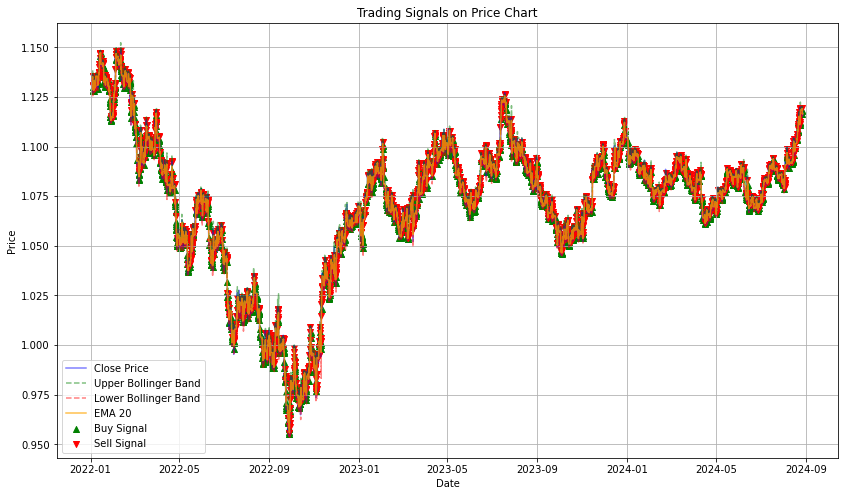

In [9]:
import matplotlib.pyplot as plt

def plot_trading_signals(df):
    plt.figure(figsize=(14, 8))
    
    # Plotting the closing prices
    plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plotting the Bollinger Bands
    plt.plot(df['BBU_20_2.0'], label='Upper Bollinger Band', color='green', linestyle='--', alpha=0.5)
    plt.plot(df['BBL_20_2.0'], label='Lower Bollinger Band', color='red', linestyle='--', alpha=0.5)
    
    # Plotting the EMA
    plt.plot(df['EMA20'], label='EMA 20', color='orange', alpha=0.7)

    # Marking Buy Signals
    buy_signals = df[df['TotalSignal'] == 2]
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)

    # Marking Sell Signals
    sell_signals = df[df['TotalSignal'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)
    
    plt.title('Trading Signals on Price Chart')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute the plot
plot_trading_signals(df)

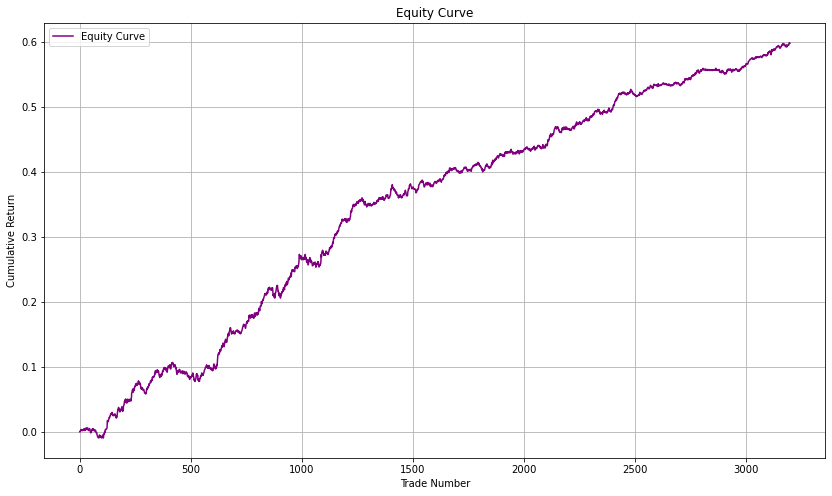

In [10]:
def plot_equity_curve(trade_results_df):
    # Calculate cumulative returns
    trade_results_df['Cumulative Return'] = trade_results_df['Result'].cumsum()

    plt.figure(figsize=(14, 8))
    
    plt.plot(trade_results_df['Cumulative Return'], label='Equity Curve', color='purple')
    plt.title('Equity Curve')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute the plot
plot_equity_curve(trade_results_df)

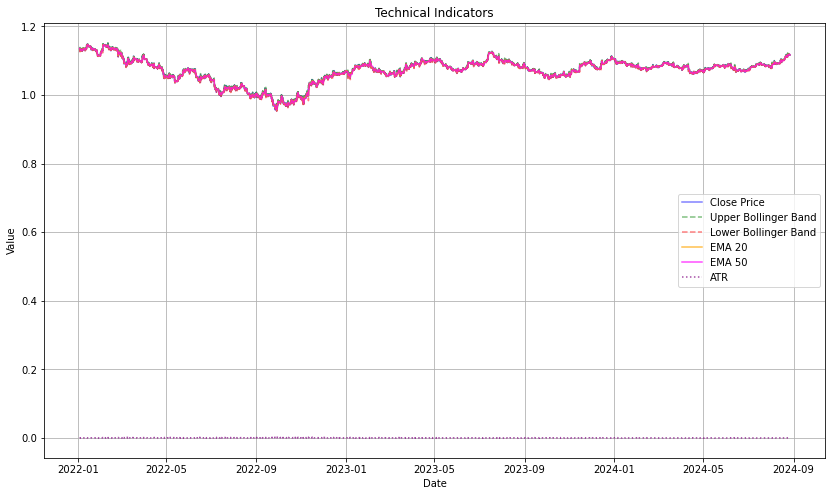

In [11]:
def plot_indicators(df):
    plt.figure(figsize=(14, 8))
    
    # Plotting the closing prices
    plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plotting the Bollinger Bands
    plt.plot(df['BBU_20_2.0'], label='Upper Bollinger Band', color='green', linestyle='--', alpha=0.5)
    plt.plot(df['BBL_20_2.0'], label='Lower Bollinger Band', color='red', linestyle='--', alpha=0.5)
    
    # Plotting the EMA
    plt.plot(df['EMA20'], label='EMA 20', color='orange', alpha=0.7)
    plt.plot(df['EMA50'], label='EMA 50', color='magenta', alpha=0.7)
    
    # Plotting the ATR
    plt.plot(df['ATR'], label='ATR', color='purple', linestyle=':', alpha=0.7)
    
    plt.title('Technical Indicators')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute the plot
plot_indicators(df)